In [80]:
import pickle
import pickle
from typing import Dict, Tuple, Optional, List, Union

import numpy as np
import pandas as pd
from pyteomics import mass
from common import LYS

from precursor import Mod, Peptide, Residue, err_margin, compute_error, within_bounds

from fragments import MultiP

from measurement import read_mgf

import fragments as fr

# FRAGMENT_FILE = "../out/fragment_matches_lys_at_2_inter_bonds_newer.pickle"
FRAGMENT_FILE = "../out/fragment_matches_lys_at_6_segments_2_breaks.pickle"
FRAGMENT_FILE = "../out/fragment_matches_lys_testing.pickle"

from protein import trypsin

In [81]:
import copy

fragments_old = copy.deepcopy(fragments)

In [82]:
fragments = []
with open(FRAGMENT_FILE, "rb") as f:
    while True:
        fragments.append(pickle.load(f))


EOFError: Ran out of input

In [40]:
df2 = pd.DataFrame(fragments)
df2

,measurement,precursor,multipeptide,bonds,match,fragment_id,fragment_mz,intensity,charge,total_intensity,score
0,<measurement.PeptideMeasurement object at 0x1d...,{'measurement': <measurement.PeptideMeasuremen...,TCVADESHAGCEKSLHTLFGDELCKVASLR+ETYGDMADCCEKQEP...,"((52, 89), (74, 90))",{'seq': 'TCVADE+ETYGDMADCCEKQEPER+TLFGDELCKVAS...,22,827.569506,3525.333984,5,64837.139404,0.054372
1,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,TCVADESHAGCEKSLHTLFGDELCKVASLR+ETYGDMADCCEKQEP...,"((52, 89), (74, 90))",{'seq': 'TCVADE+ETYGDMADCCEKQEPER+TLFGDELCKVAS...,22,827.569506,3525.333984,5,64837.139404,0.054372
2,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,TCVADESHAGCEKSLHTLFGDELCKVASLR+ETYGDMADCCEKQEP...,"((52, 90), (74, 89))",{'seq': 'TCVADE+ETYGDMADCCEKQEPER+TLFGDELCKVAS...,22,827.569506,3525.333984,5,64837.139404,0.054372
3,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,TCVADESHAGCEKSLHTLFGDELCKVASLR+ETYGDMADCCEKQEP...,"((52, 90), (74, 89))",{'seq': 'TCVADE+ETYGDMADCCEKQEPER+TLFGDELCKVAS...,22,827.569506,3525.333984,5,64837.139404,0.054372


In [ ]:
df = pd.DataFrame(fragments)
df

In [46]:
[m.scan for m in df["measurement"]]

[5368, 5368, 5368, 5368]

In [49]:
x = df2[[m.scan == 5368 for m in df2["measurement"]]]
x["prec_error"] = [p["error"] for p in x["precursor"]]
x["breaks"] = [m["breaks"] for m in x["match"]]
x

<ipython-input-49-b6910ce0248c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["prec_error"] = [p["error"] for p in x["precursor"]]
<ipython-input-49-b6910ce0248c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["breaks"] = [m["breaks"] for m in x["match"]]


,measurement,precursor,multipeptide,bonds,match,fragment_id,fragment_mz,intensity,charge,total_intensity,score,prec_error,breaks
16476,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+TPGSRNLCNIPCSALLSSDITASVNCAK+IVSDGNGM...,"((5, 75), (79, 114), (93, 126))","{'seq': 'ELAAA', 'ranges': [(6, 11)], 'mass': ...",3,110.314205,1570.352783,4,64837.139404,0.024220,3.018654,2
16477,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+TPGSRNLCNIPCSALLSSDITASVNCAK+IVSDGNGM...,"((5, 75), (79, 114), (93, 126))","{'seq': 'SDGNGM', 'ranges': [(99, 105)], 'mass...",6,116.442766,1842.278564,5,64837.139404,0.028414,3.018654,2
16478,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+TPGSRNLCNIPCSALLSSDITASVNCAK+IVSDGNGM...,"((5, 75), (79, 114), (93, 126))","{'seq': 'DITASVNCAK+AWIRGCR', 'ranges': [(86, ...",20,470.738987,2533.983643,4,64837.139404,0.039082,3.018654,2
16479,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+TPGSRNLCNIPCSALLSSDITASVNCAK+IVSDGNGM...,"((5, 75), (79, 114), (93, 126))",{'seq': 'CELAAAMK+TPGSRNLCNIPCSALLSSDITASVNCAK...,23,1410.273820,3609.701660,5,64837.139404,0.055673,3.018654,2
16480,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+TPGSRNLCNIPCSALLSSDITASVNCAK+IVSDGNGM...,"((5, 75), (79, 114), (93, 126))",{'seq': 'IPCSALLSSDITASVNCAK+VAWRNRCK+GTDVQAWI...,25,1427.723296,3515.836914,3,64837.139404,0.054226,3.018654,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16676,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,FESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSR+NLCNI...,"((63, 93), (79, 114))",{'seq': 'NSRWWCNDGRTPG+NLCNIPCSALLSSDITASVNCAK...,22,827.569506,3525.333984,5,64837.139404,0.054372,14.258737,2
16677,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,FESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSR+NLCNI...,"((63, 93), (79, 114))",{'seq': 'NSRWWCNDGRTPG+NLCNIPCSALLSSDITASVNCAK...,22,827.569506,3525.333984,5,64837.139404,0.054372,14.258737,2
16678,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,FESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSR+NLCNI...,"((63, 93), (75, 114))",{'seq': 'FESNFNTQATNRNTDGSTDYGILQINSRWWCND+CAK...,22,827.569506,3525.333984,5,64837.139404,0.054372,14.258737,2
16679,<measurement.PeptideMeasurement object at 0x1e...,{'measurement': <measurement.PeptideMeasuremen...,FESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSR+NLCNI...,"((63, 93), (75, 114))",{'seq': 'NSRWWCNDGRTPG+NLCNIPCSALLSSDITASVNCAK...,22,827.569506,3525.333984,5,64837.139404,0.054372,14.258737,2


In [20]:
import matplotlib.pyplot as plt


def histo(data):
    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(
        x=data,
        bins="auto",
        color="#0504aa",
        alpha=0.7,
        rwidth=0.85,
    )
    plt.grid(axis="y", alpha=0.75)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("My Very Own Histogram")
    plt.text(23, 45, r"$\mu=15, b=3$")
    plt.xticks(rotation=90)
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    return plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


flattened = [(b[0] + 1, b[1] + 1) for m in df.bonds for b in m]
histo([str(b) for b in sorted(flattened)])

In [177]:
# From old fragment analysis
# ((6, 127), 13.346290121050531)
# ((30, 115), 7.283808779510653)
# ((94, 115), 4.902732231508441)
# ((30, 127), 4.175014297421382)
# ((6, 76), 3.5228414463338105)
# ((6, 115), 3.4146538279373413)
# ((80, 115), 2.652638582827121)
# ((76, 80), 1.8027670677845962)
# ((64, 127), 1.6640611786956967)
# ((94, 127), 1.6384830750559505)
# ((80, 127), 1.6018448515043544)
# ((76, 94), 1.5866929809330261)
# ((6, 64), 1.4861990294897955)
# ((64, 76), 1.171054578671526)
# ((6, 94), 1.1382788403829496)
# ((30, 76), 1.0597983564585203)
# ((6, 80), 1.0528272625199064)
# ((64, 115), 0.9401018143378905)
# ((115, 127), 0.9266341801551622)
# ((76, 127), 0.5575763428777898)
# ((30, 94), 0.48211151877450525)
# ((6, 30), 0.41906206956130065)
# ((76, 115), 0.3512598674841227)
# ((64, 94), 0.23690502620184029)
# ((30, 64), 0.23429644150417078)
# ((64, 80), 0.1591891546235903)
# ((80, 94), 0.031476791393323385)


[6276]

In [357]:
d = pd.DataFrame()

d["scan"] = [m.scan for m in df["measurement"]]
d["precursor_seq"] = [str(m) for m in df["multipeptide"]]
d["precursor_charge"] = [m.charge for m in df["measurement"]]
d["precursor_bonds"] = ["+".join(str(r) for r in b) for b in df["bonds"]]
d["match_seq"] = [m["seq"] for m in df["match"]]
d["charge"] = df["charge"]
d["match_ranges"] = ["+".join(str(r) for r in m["ranges"]) for m in df["match"]]
d["match_mass"] = [m["mass"] for m in df["match"]]
d["connected_bonds"] = [
    "+".join(str(r) for r in m["connected_bonds"]) for m in df["match"]
]
d["disconnected_cys"] = [
    "+".join(str(c) for c in m["disconnected_cys"]) for m in df["match"]
]
d["interesting_disconnected_cys"] = [
    "+".join(str(c) for c in m["interesting_disconnected_cys"]) for m in df["match"]
]

d["match_error_ppm"] = [m["error"] for m in df["match"]]
d["target_mz"] = df["fragment_mz"]
d["intensity"] = df["intensity"]
d["total_intensity"] = df["total_intensity"]

COUNTER = 0
MULTIP_IDS = {}


def multip_id(mp: MultiP):
    key = mp
    global COUNTER
    if mp in MULTIP_IDS:
        return MULTIP_IDS[mp]
    COUNTER += 1
    return MULTIP_IDS.setdefault(
        mp,
    )


In [98]:
d.to_csv("../out/csv/fragment_matches.csv", index_label="id", sep=";")

In [96]:
precursor_matches = []
with open("../out/precursor_matches_lys_at_6_segments.pickle", "rb") as f:
    while True:
        precursor_matches.append(pickle.load(f))

EOFError: Ran out of input

In [95]:
precursor_matches_2 = []
with open("../out/precursor_matches/LYS_AT_segments=6_error=15ppm.pickle", "rb") as f:
    while True:
        precursor_matches_2.append(pickle.load(f))

EOFError: Ran out of input

In [342]:
from pyteomics.mass import calculate_mass

precursor_matches_df = pd.DataFrame(precursor_matches)
precursor_matches_df["spectrum_id"] = [
    m.id for m in precursor_matches_df["measurement"]
]
precursor_matches_df["scan"] = [m.scan for m in precursor_matches_df["measurement"]]
precursor_matches_df["my_mz"] = [
    (m / msmnt.charge) + calculate_mass(formula="H")
    for m, msmnt in zip(
        precursor_matches_df["mass"], precursor_matches_df["measurement"]
    )
]
precursor_matches_df = precursor_matches_df[
    [
        "spectrum_id",
        "scan",
        "my_mz",
        "error",
        "sequence",
        "mods",
        "cys_bonds",
        "missed_cleavages",
    ]
]

precursor_matches_df = precursor_matches_df.rename(
    columns={
        "error": "my_error_ppm",
        "sequence": "my_sequence",
        "mods": "my_mods",
        "missed_cleavages": "my_missed_cleavages",
    }
)
precursor_matches_df = precursor_matches_df.set_index("spectrum_id")
precursor_matches_df

,scan,my_mz,my_error_ppm,my_sequence,my_mods,cys_bonds,my_missed_cleavages
spectrum_id,,,,,,,
71,903,515.763038,0.639187,RHGLDNYR,(),0,1
101,934,355.844694,0.005825,CELAAAMKR,"(Mod(description='Met Oxidation', mass=15.9949...",0,1
113,947,533.263128,1.135656,CELAAAMKR,"(Mod(description='Met Oxidation', mass=15.9949...",0,1
146,982,437.712482,0.096751,HGLDNYR,(),0,0
198,1040,355.844694,0.338194,CELAAAMKR,"(Mod(description='Met Oxidation', mass=15.9949...",0,1
...,...,...,...,...,...,...,...
14500,16195,1363.294827,6.163145,CELAAAMKRHGLDNYRGYSLGNWVCAAK+WWCNDGR,"(Mod(description='Alkylated Cys', mass=57.0214),)",1,3
14506,16205,409.975343,1.414521,KVFGRCELAAAMKR,"(Mod(description='Alkylated Cys', mass=57.0214),)",0,3
14507,16207,714.829303,1.086133,FESNFNTQATNR,(),0,0


In [349]:
from pymzid.read_mzid import Mzid
from fragments import compute_error

mgf_id = Mzid("../data/mgf/190318_LYS_RAT_50x_05.mzid")
mgf_id.read_psm()
msgf_matches_df = mgf_id.psm_df

msgf_matches_df.head(30)

Reading peptide spectrum matches: 100%|█████████▉| 1217/1218 [00:00<00:00, 42781.09it/s]


,sir_id,spectrum_id,pe_id,sii_id,z,mz,calc_mz,pep_id,pass_threshold,rank,MS-GF:RawScore,MS-GF:DeNovoScore,MS-GF:SpecEValue,MS-GF:EValue
0,SIR_5123,index=5122,PepEv_22_GYSLGNWVCAAKFESNFNTQATNR_22,SII_5123_1,3,912.427001953125,912.435791015625,Pep_GYSLGNWVCAAKFESNFNTQATNR,true,1,175,176,1.9008859E-30,2.4521429E-28
1,SIR_4648,index=4647,PepEv_22_GYSLGNWVCAAKFESNFNTQATNR_22,SII_4648_1,3,912.42822265625,912.435791015625,Pep_GYSLGNWVCAAKFESNFNTQATNR,true,1,167,169,4.8748996E-30,6.2886206E-28
2,SIR_4370,index=4369,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_4370_1,3,1055.162109375,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,159,174,2.1087976E-27,2.7203489E-25
3,SIR_4503,index=4502,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_4503_1,3,1055.162109375,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,155,165,5.184633E-27,6.6881767E-25
4,SIR_4433,index=4432,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_4433_1,3,1055.498046875,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,153,171,2.9292433E-26,3.778724E-24
5,SIR_4781,index=4780,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_4781_1,3,1055.1624755859375,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,115,141,1.0629297E-25,1.3711793E-23
6,SIR_12433,index=12432,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_12433_1,3,1055.1634521484375,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,130,152,1.7940855E-25,2.3143704E-23
7,SIR_5083,index=5082,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_5083_1,3,1055.1627197265625,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,128,147,7.9793734E-25,1.02933916E-22
8,SIR_10326,index=10325,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_10326_1,3,1055.16357421875,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,118,134,9.035872E-25,1.1656276E-22
9,SIR_5839,index=5838,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_5839_1,3,1055.163330078125,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,93,111,1.8105348E-24,2.33559E-22


In [ ]:
msgf_matches_df["spectrum_id"] = [
    int(s.removeprefix("index=")) for s in msgf_matches_df["spectrum_id"]
]
msgf_matches_df["pep_id"] = [s.removeprefix("Pep_") for s in msgf_matches_df["pep_id"]]
msgf_matches_df["their_error_ppm"] = [
    compute_error(float(reference), float(measured))
    for reference, measured in zip(msgf_matches_df["calc_mz"], msgf_matches_df["mz"])
]

msgf_matches_df = msgf_matches_df[
    ["spectrum_id", "calc_mz", "pep_id", "their_error_ppm"]
]
msgf_matches_df = msgf_matches_df.rename(
    columns={"pep_id": "their_sequence", "calc_mz": "their_mz"}
)
msgf_matches_df = msgf_matches_df.set_index("spectrum_id")
msgf_matches_df

In [345]:
precursor_matches_df.join(msgf_matches_df, how="outer").to_csv(
    "../out/my_vs_their_matches_rat.csv"
)

In [317]:
measurements[3104].peptide_mass_estimate - calculate_mass("NTDGSTDYGILQINSR")

0.018651695947937696

In [ ]:
protein = LYS
cysteines = [i for i in range(len(protein)) if protein[i] == "C"]

In [ ]:
from collections import Counter

segment_counter = Counter()
for m in precursor_matches:
    for b, e in m["ranges"]:
        for s in range(b, e):
            segment_counter[s] += 1
segment_counter

In [ ]:
segments = list(segment_counter.keys())
total = sum(segment_counter.values())
segment_probabilities = []
for s in range(min(segments), max(segments) + 1):
    segment_probabilities.append(segment_counter[s] / total)
segment_probabilities

In [ ]:
precursor_probabilities = []
for f in fragments:
    probability = 1
    for b, e in f["precursor"]["ranges"]:
        for s in range(b, e):
            probability *= segment_probabilities[s]
    precursor_probabilities.append(probability)
precursor_probabilities[:10]

In [91]:
import networkx as nx
import matplotlib.pyplot as plt

import itertools
from collections import Counter

possible_bonds = list(itertools.combinations(cysteines, 2))
positive_evidence = {b: 0 for b in possible_bonds}
negative_evidence = {b: 0 for b in possible_bonds}
alkylation_score = {c: 0 for c in cysteines}

DIRECT_POS_WEIGHT = 1
NEG_WEIGHT = 1
INDIRECT_POS_WEIGHT = 1
NEG_ALK_WEIGHT = 1

from pprint import pprint

for m, prob in zip(fragments, precursor_probabilities):
    P = prob
    cys_in_bonds = []

    for b in m["match"]["connected_bonds"]:
        positive_evidence[b] += P * DIRECT_POS_WEIGHT
        cys_in_bonds += list(b)
        for x, y in negative_evidence:
            if (x, y) != b and (x in b or y in b):
                # We're looking at A<–>B, every other bond with A or B is decreased
                negative_evidence[(x, y)] += P * NEG_WEIGHT

    for c in m["match"]["interesting_disconnected_cys"]:
        cys_in_bonds.append(c)
        for b in positive_evidence:
            if c in b:
                positive_evidence[b] += P * INDIRECT_POS_WEIGHT

    if len(cys_in_bonds) != len(set(cys_in_bonds)):
        print(m["measurement"].scan)
        # assert len(cys_in_bonds) == len(set(cys_in_bonds))

    for c in cysteines:
        if c not in cys_in_bonds and any(b <= c < e for b, e in m["match"]["ranges"]):
            alkylation_score[c] += P * NEG_ALK_WEIGHT


KeyError: (61, 100)

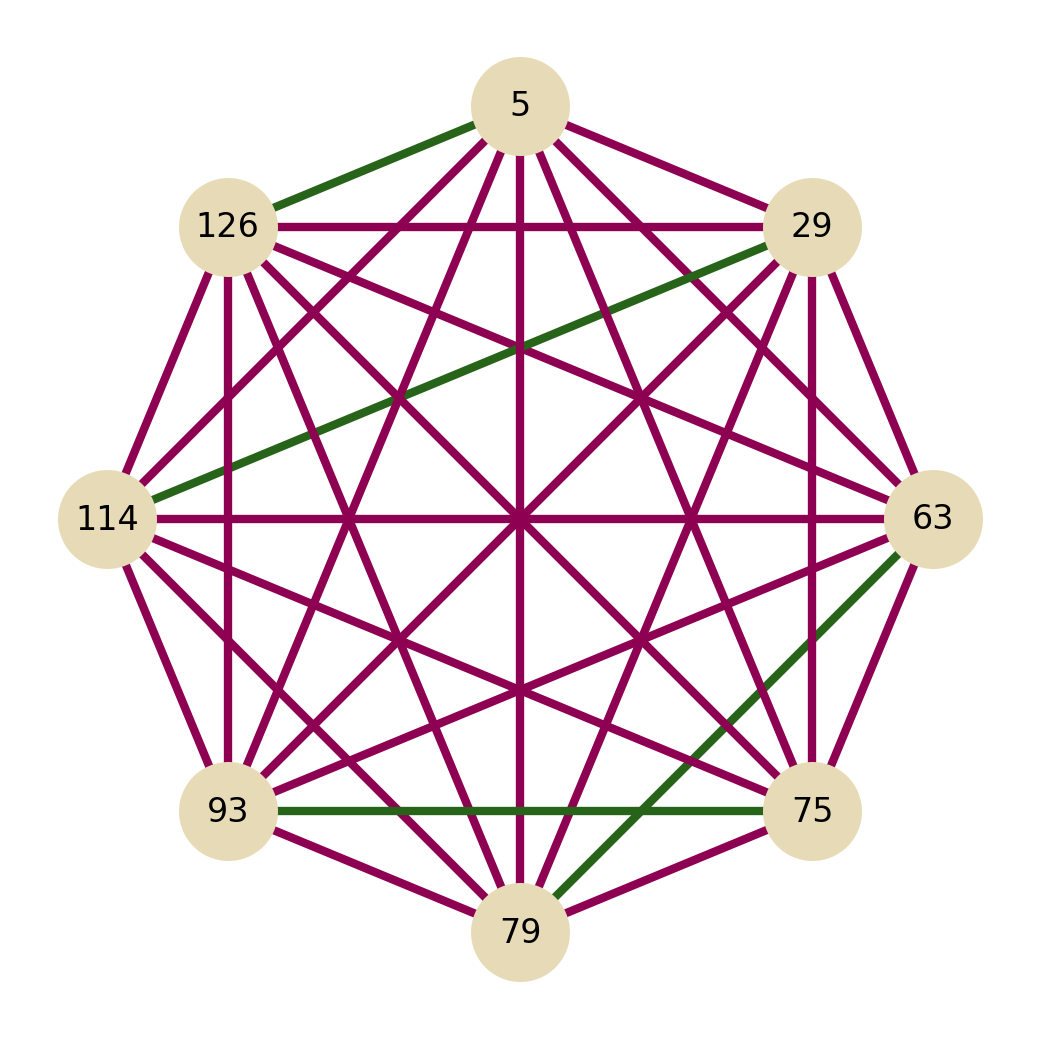

In [84]:
CMAP = plt.get_cmap("PiYG")

BSA_BONDS = [
    (b - 1, e - 1)
    for b, e in [
        (53, 62),
        (75, 91),
        (90, 101),
        (123, 168),
        (167, 176),
        (199, 245),
        (244, 252),
        (264, 278),
        (277, 288),
        (315, 360),
        (359, 368),
        (391, 437),
        (436, 447),
        (460, 476),
        (475, 486),
        (513, 558),
        (557, 566),
    ]
]

LYS_BONDS = [(5, 126), (29, 114), (63, 79), (75, 93)]

# IDEAL GRAPH
g = nx.complete_graph(reversed(cysteines[3:] + cysteines[:3]))
plt.figure(figsize=(5, 5), dpi=200)

edges = [tuple(sorted(e)) for e in g.edges()]
scores = [e in LYS_BONDS for e in edges]
scores_normalized = [
    abs(s - min(scores)) / abs(max(scores) - min(scores)) for s in scores
]
colors = [CMAP(s) for s in scores_normalized]

nx.draw_circular(
    g,
    with_labels=True,
    node_size=1200,
    node_color="#E7DBB7",
    edge_color=colors,
    width=3,
)

In [92]:
nodes = list(reversed(cysteines[3:] + cysteines[:3]))
g = nx.complete_graph(nodes)
plt.figure(figsize=(5, 5), dpi=200)

edges = [tuple(sorted(e)) for e in g.edges()]
scores = [(positive_evidence[e]) - negative_evidence[e] for e in edges]
scores_normalized = [
    abs(s - min(scores)) / abs(max(scores) - min(scores)) for s in scores
]
edge_colors = [CMAP(s) for s in scores_normalized]

node_scores = [
    (alkylation_score[n] - sum(positive_evidence[e] for e in edges if n in e))
    for n in nodes
]
node_scores_normalized = [
    abs(s - min(node_scores)) / abs(max(node_scores) - min(node_scores))
    for s in node_scores
]
node_colors = [CMAP(s) for s in node_scores_normalized]


nx.draw_circular(
    g,
    with_labels=True,
    node_size=1200,
    node_color="#E7DBB7",
    linewidths=3,
    edgecolors=node_colors,
    edge_color=edge_colors,
    width=3,
)

ZeroDivisionError: division by zero

<Figure size 1000x1000 with 0 Axes>

In [93]:
len(fragments)

7801

In [94]:
len(fragments_old)

139226